In [1]:
# library
import os
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display as ipD
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
# path
DATA_ROOT = Path("../input/rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/train")
TEST_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/test")
OUT_TRAIN = Path("../input/rfcx-species-audio-detection/train_mel_clip")
OUT_TEST = Path("../input/rfcx-species-audio-detection/test_mel_clip")

In [3]:
# train and test
df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})

In [4]:
# 5 -
class params:
    sr = 48000
    n_mels = 320
    fmin = 40
    fmax = sr // 2
    fft = 2048
    hop = 512
    clip_frame = 12 * 48000

In [5]:
# Data load
df_train_tp = pd.read_csv(Path("../input/rfcx-species-audio-detection/train_tp.csv"))
df_train_tp.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

In [6]:
df_train_tp["t_dur"] = df_train_tp["t_max"] - df_train_tp["t_min"]
df_train_tp.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max  \
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25   
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40   
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25   
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04   
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70   

    t_dur  
0  0.5867  
1  6.0837  
2  3.1360  
3  3.7790  
4  2.4439

In [7]:
# how max???
df_train_tp["t_dur"].max()

7.923900000000003

In [8]:
# load
def load_audio(record, sr=48000, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".flac").as_posix(),
        sr=sr, 
    )
    return y, _

In [9]:
def wav_to_mel(row, isVizMel=False):
    wav, sr = load_audio(row["recording_id"], params.sr, TRAIN_AUDIO_ROOT)

    t_min = float(row["t_min"]) * params.sr
    t_max = float(row["t_max"]) * params.sr

    # Positioning sound slice
    center = np.round((t_min + t_max) / 2)
    beginning = center - (params.clip_frame / 2)
    if beginning < 0:
        beginning = 0

    ending = beginning + params.clip_frame
    if ending > len(wav):
        ending = len(wav)
        beginning = ending - params.clip_frame

    slice = wav[int(beginning):int(ending)]

    # tomel
    melspec = lb.feature.melspectrogram(
        slice, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)

    if isVizMel:
        fig, ax = plt.subplots(figsize=(15, 5))
        img = librosa.display.specshow(
            melspec, 
            sr=params.sr,
            x_axis='time', 
            y_axis='linear', 
            ax=ax)
        ax.set(title=f'Mel-frequency spectrogram of {row["recording_id"]}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")

        ax.add_patch(
                patches.Rectangle(xy=((t_min - beginning) / params.sr, row["f_min"]), width=(t_max-t_min) / params.sr, height=row["f_max"] - row["f_min"], ec='#00ff00', fill=False)
            )
        ax.text((t_min - beginning) / params.sr, row["f_max"], 
        f"{row['recording_id']}",
        horizontalalignment='left', verticalalignment='bottom', color='#00ff00', fontsize=16)
        plt.show()

    return melspec


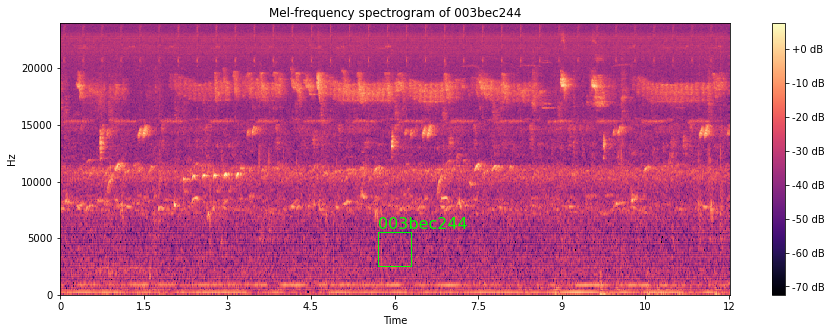

(320, 1126)


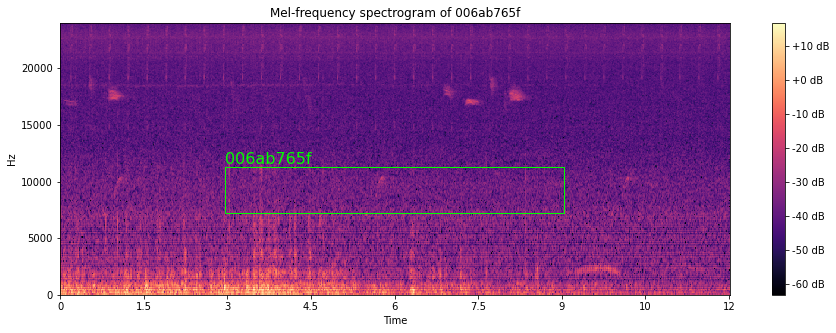

(320, 1126)


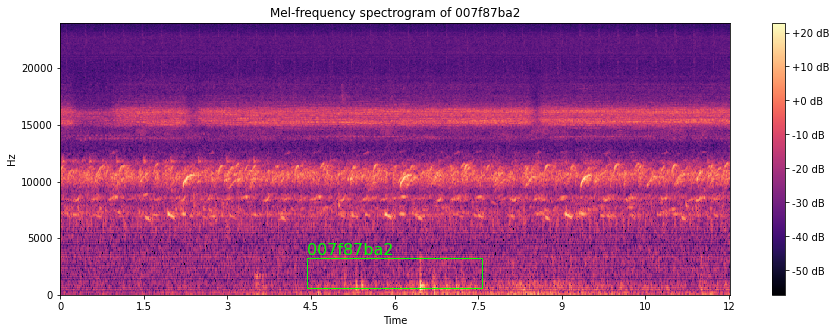

(320, 1126)



In [10]:
# test
for index, row in tqdm(df_train_tp.head(3).iterrows()):
    # wav to mel
    melspec = wav_to_mel(row, True)
    print(melspec.shape)

In [133]:
# save train
ids = []
specids = []
recids = []
for index, row in tqdm(df_train_tp.iterrows()):
    # wav to mel
    melspec = wav_to_mel(row, False)

    # normalize
    melspec = melspec - np.min(melspec)
    melspec = melspec / np.max(melspec)

    # save
    np.save(os.path.join(OUT_TRAIN, str(index) + ".npy"), melspec)

    # for dict
    ids.append(index)
    specids.append(row["species_id"])
    recids.append(row["recording_id"])
    

In [136]:
# save input
df_train_mel = pd.DataFrame.from_dict({'id': ids, 'species_id': specids, 'recording_id': recids})
df_train_mel.to_csv(Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"), index=False)
df_train_mel.head()

id  species_id recording_id
0   0          14    003bec244
1   1          23    006ab765f
2   2          12    007f87ba2
3   3          17    0099c367b
4   4          10    009b760e6

In [11]:
# in test, devide 6
def wav_to_mel_test(recid, isVizMel=False):
    wav, sr = load_audio(recid, params.sr, TEST_AUDIO_ROOT)

    # tomel
    melspec = lb.feature.melspectrogram(
        wav, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
    )
    melspec = lb.power_to_db(melspec).astype(np.float32)

    if isVizMel:
        fig, ax = plt.subplots(figsize=(15, 5))
        img = librosa.display.specshow(
            melspec, 
            sr=params.sr,
            x_axis='time', 
            y_axis='linear', 
            ax=ax)
        ax.set(title=f'Mel-frequency spectrogram of {recid}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")

    return melspec


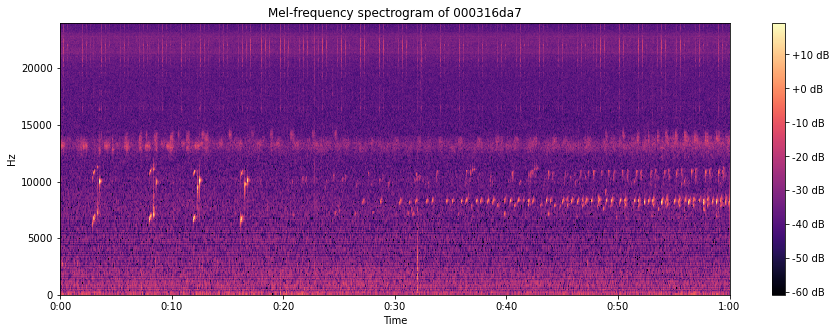

In [13]:
# test
for recid in tqdm(df_test.values[0]):
    # wav to mel
    melspec = wav_to_mel_test(recid, True)

In [14]:
# save
for recid in tqdm(df_test.values):
    # wav to mel
    melspec = wav_to_mel_test(recid[0], False)

    # normalize
    melspec = melspec - np.min(melspec)
    melspec = melspec / np.max(melspec)

    # save
    np.save(os.path.join(OUT_TEST, recid[0] + ".npy"), melspec)